# Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import scipy as sp
from scipy import stats
%matplotlib inline

# Import mark (upload) dataset

In [2]:
dataUpload = pd.read_csv('~/Python_data_analytics/einstein/analysis/uploads1.csv', sep=",")

In [3]:
pd.options.display.max_colwidth = 100 #show full string value

In [4]:
dataUpload['date'] = pd.to_datetime(dataUpload.date)
dataUpload = dataUpload.set_index('date')
dataUpload = dataUpload.sort_index()

# Aggregate mark (upload) 

In [5]:
uploadSumGroupedbyWeek = dataUpload.groupby([pd.Grouper(freq='12W'),pd.Grouper(key='user')]).sum()
uploadCountGroupedbyWeek = dataUpload.groupby([pd.Grouper(freq='12W'),pd.Grouper(key='user')]).count()

In [6]:
filterSemester1 = uploadSumGroupedbyWeek.loc['2018-09-30':'2018-09-30']
#calculate the average mark of each student
filterSemester1.loc[:,'mark'] = filterSemester1.loc[:,'passed']/(filterSemester1.loc[:,'passed'] + filterSemester1.loc[:,'failed'])
filterSemester1.loc[:,'mark_overall'] = filterSemester1.loc[:,'correct']/uploadCountGroupedbyWeek.loc[:,'correct']

/home/tai/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/tai/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Import learning process data

In [7]:
activity = pd.read_csv('~/Python_data_analytics/einstein/analysis/activity1.csv', sep=",")
activity = activity.drop(activity.index[140608])
activity.loc[:,'time:timestamp'] = pd.to_datetime(activity['time:timestamp'])
activity = activity.set_index('time:timestamp')
#activity = activity.sort_index()
activity = activity.loc['2018-09-24':'2018-12-16']

# Merge learning process & mark data

In [8]:
tempAct = activity.loc[activity['concept:instance'] == 'load']
tempAct = tempAct.groupby([pd.Grouper(freq='12W'),pd.Grouper(key='org:resource')]).count()

#to check how many students in each week
for index, row in tempAct.groupby(level=0):
    print(str(index) + '  ' + str(len(row)))

2018-09-30 00:00:00  120
2018-12-23 00:00:00  126


In [9]:
activityList = ['load','scroll','focus','blur','unload']
""" ,'hashchange','click-0','selection','click-2 ','click-1' """
combinedActivityMarkByWeek = []

for al in activityList:
    tempAct = activity.loc[activity['concept:instance'] == al]
    tempAct = tempAct.groupby([pd.Grouper(freq='W'),pd.Grouper(key='org:resource')]).count()
    tempAct[al] = tempAct['concept:instance']
    tempAct.drop(['case:concept:name','concept:instance','concept:name','lifecycle:transition','description'], axis=1, inplace=True)    
    
    tempCombinedData = []
    if len(combinedActivityMarkByWeek) > 0:        
        combinedActivityMarkByWeek = pd.merge(combinedActivityMarkByWeek,tempAct, left_on=combinedActivityMarkByWeek.index, right_on=tempAct.index)    
        print(len(combinedActivityMarkByWeek))
    else:
        combinedActivityMarkByWeek = pd.merge(filterSemester1,tempAct, left_on=filterSemester1.index, right_on=tempAct.index)
        print(len(combinedActivityMarkByWeek))
    combinedActivityMarkByWeek.index = pd.MultiIndex.from_tuples(combinedActivityMarkByWeek['key_0'], names=('date', 'user')) 
    combinedActivityMarkByWeek.drop(['key_0'], axis = 1, inplace=True) 
    
#combinedActivityMarkByWeek    

115
115
115
115
109


# Construct cohort dataset

In [10]:
#based on percentile
   
excellentCohort = pd.DataFrame()
goodCohort = pd.DataFrame()
mediumCohort = pd.DataFrame()
badCohort = pd.DataFrame()

for index, weeklyData in combinedActivityMarkByWeek.groupby(level=0):
    excellentPoint = 0.7 #np.percentile(weeklyData['mark'],75)
    goodPoint = 0.6#np.percentile(weeklyData['mark'],50)
    mediumPoint = 0.5#np.percentile(weeklyData['mark'],25)
        
    excellentCohort = pd.concat([excellentCohort,weeklyData.loc[weeklyData['mark'] >= excellentPoint]])
    goodCohort = pd.concat([goodCohort,weeklyData.loc[(weeklyData['mark'] < excellentPoint) & (weeklyData['mark'] >= goodPoint)]])
    mediumCohort = pd.concat([mediumCohort,weeklyData.loc[(weeklyData['mark'] < goodPoint) & (weeklyData['mark'] >= mediumPoint)]])
    badCohort = pd.concat([badCohort,weeklyData.loc[(weeklyData['mark'] < mediumPoint)]])

print('Excellent cohort:')
for i,row in excellentCohort.groupby(level=0):
    print(len(row))
print('Good cohort:')
for i,row in goodCohort.groupby(level=0):
    print(len(row))
print('Medium cohort:')
for i,row in mediumCohort.groupby(level=0):
    print(len(row))
print('Bad cohort:')
for i,row in badCohort.groupby(level=0):
    print(len(row)) 


Excellent cohort:
32
Good cohort:
36
Medium cohort:
24
Bad cohort:
17


# PCA for each cohort

In [11]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

loadingsArrayExcellentCohortArray = []
pcValueExcellentCohortArray = []

loadingsArrayBadCohortArray = []
pcValueBadCohortArray = []

loadingsArrayGoodCohortArray = []
pcValueGoodCohortArray = []

loadingsArrayMediumCohortArray = []
pcValueMediumCohortArray = []

pca = PCA(n_components=5)
dropColumn1 = ['correct','failed','passed','version','timeout',
                                'mark','mark_overall']
for datasetName, dataset in zip(['excellent','bad','good','medium'],
                                [excellentCohort,badCohort, goodCohort, mediumCohort]):
    for i,weeklyActivity in dataset.groupby(level=0):
        temp = weeklyActivity.drop(dropColumn1, axis=1)    
        x = temp.values    
        #x_adjust = x - np.mean(x)    
        scaler.fit(x)
        x = scaler.transform(x)
        pca.fit(x)
        # transformed value to array
        transformed_value = pca.fit_transform(x)
        countValue = 0
        for t in transformed_value:
            row_list = []
            row_list.append(i)
            countValue1 = 0
            for u,tp in weeklyActivity.groupby(level=1):
                if countValue == countValue1:
                    row_list.append(u)
                countValue1 = countValue1 + 1
            for v in t:
                row_list.append(v)
            if datasetName == 'excellent':
                pcValueExcellentCohortArray.append(row_list)
            elif datasetName == 'bad':
                pcValueBadCohortArray.append(row_list)
            elif datasetName == 'good':
                pcValueGoodCohortArray.append(row_list)
            elif datasetName == 'medium':
                pcValueMediumCohortArray.append(row_list)
            else:
                print('error')
            countValue = countValue + 1

        count = 1    
        # eigenvectors/loadings to array
        for k,l in zip(pca.explained_variance_ratio_,pca.explained_variance_):
            row_list = []
            row_list.append(i)
            row_list.append(count)
            row_list.append(k)
            row_list.append(l)
            for j in pca.components_[count-1]:
                row_list.append(j)
            if datasetName == 'excellent':
                loadingsArrayExcellentCohortArray.append(row_list)
            elif datasetName == 'bad':
                loadingsArrayBadCohortArray.append(row_list)
            elif datasetName == 'good':
                loadingsArrayGoodCohortArray.append(row_list)
            elif datasetName == 'medium':
                loadingsArrayMediumCohortArray.append(row_list)
            else:
                print('error')
            count = count + 1
        
#loadings
ccolumns = ['date','pc','explained_var_ratio','eigenvalues','load','scroll','focus','blur','unload']
loadingsArrayExcellentCohort = pd.DataFrame(loadingsArrayExcellentCohortArray,columns=ccolumns)
loadingsArrayExcellentCohort = loadingsArrayExcellentCohort.set_index(['date', 'pc'])

column11 = ['date','user','pc1','pc2','pc3','pc4','pc5']
#transformed value (principal components)
pcValueExcellentCohort = pd.DataFrame(pcValueExcellentCohortArray,columns=column11)
pcValueExcellentCohort = pcValueExcellentCohort.set_index(['date','user']);

loadingsArrayBadCohort = pd.DataFrame(loadingsArrayBadCohortArray,columns=ccolumns)
loadingsArrayBadCohort = loadingsArrayBadCohort.set_index(['date', 'pc'])

#transformed value (principal components)
pcValueBadCohort = pd.DataFrame(pcValueBadCohortArray,columns=column11)
pcValueBadCohort = pcValueBadCohort.set_index(['date','user'])

loadingsArrayGoodCohort = pd.DataFrame(loadingsArrayGoodCohortArray,columns=ccolumns)
loadingsArrayGoodCohort = loadingsArrayGoodCohort.set_index(['date', 'pc'])

#transformed value (principal components)
pcValueGoodCohort = pd.DataFrame(pcValueGoodCohortArray,columns=column11)
pcValueGoodCohort = pcValueGoodCohort.set_index(['date','user'])

loadingsArrayMediumCohort = pd.DataFrame(loadingsArrayMediumCohortArray,columns=ccolumns)
loadingsArrayMediumCohort = loadingsArrayMediumCohort.set_index(['date', 'pc'])

#transformed value (principal components)
pcValueMediumCohort = pd.DataFrame(pcValueMediumCohortArray,columns=column11)
pcValueMediumCohort = pcValueMediumCohort.set_index(['date','user'])

/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input 

In [13]:
def getNumberOfPCs(df,acceptedPercentage):
    temp = df['explained_var_ratio']
    sumContrPer = 0
    for i,j in zip(temp,range(0,len(temp))):
        sumContrPer = sumContrPer + i
        if sumContrPer >= acceptedPercentage:
            break
    return [sumContrPer,j]

def contrCal(df,numOfPCs):
    #get sum of eigenvalues of the first number of PCs in df
    totalContrPCs = sum(df['eigenvalues'].head(numOfPCs))
    #calculate contribution of variables into number of PCs
    temp = pd.DataFrame(columns=df.columns)
    listContr = []
    columns = df.columns
    for c in columns:        
        if c not in ['explained_var_ratio','eigenvalues']:
            temp[c] = df[c]*df[c]*df['eigenvalues']
            temp1 = [c,sum(temp[c].head(numOfPCs))/totalContrPCs]            
            listContr.append(temp1)
    result = pd.DataFrame(listContr,columns=['transition','contr_percentage'])
    return result

In [12]:
loadingsArrayExcellentCohort

explained_var_ratio  eigenvalues      load    scroll     focus  \
date       pc                                                                   
2018-09-30 1              0.501834     2.590113  0.421529  0.507479  0.463449   
           2              0.288966     1.491436  0.373189 -0.162070 -0.514368   
           3              0.121744     0.628357  0.638430  0.369808 -0.164359   
           4              0.080309     0.414498 -0.509549  0.761087 -0.349637   
           5              0.007147     0.036887 -0.125738  0.013672  0.609410   

                   blur    unload  
date       pc                      
2018-09-30 1   0.559659  0.191770  
           2   0.033402  0.754170  
           3  -0.569292 -0.323331  
           4  -0.078733  0.180722  
           5  -0.596133  0.507197

In [17]:
numberOfPcs = getNumberOfPCs(loadingsArrayExcellentCohort,0.30)[1]

resultExcellent = contrCal(loadingsArrayExcellentCohort,1)

In [18]:
resultExcellent

,transition,contr_percentage
0,load,0.177687
1,scroll,0.257535
2,focus,0.214785
3,blur,0.313218
4,unload,0.036776


In [19]:
loadingsArrayBadCohort

explained_var_ratio  eigenvalues      load    scroll     focus  \
date       pc                                                                   
2018-09-30 1              0.640577     3.403064 -0.509157 -0.479521 -0.473011   
           2              0.247740     1.316120  0.109161 -0.167912 -0.414731   
           3              0.068394     0.363344  0.178344  0.744850 -0.437038   

                   blur    unload  
date       pc                      
2018-09-30 1  -0.517199 -0.139947  
           2   0.193084  0.866375  
           3  -0.471250  0.017704

In [19]:
numberOfPcs = getNumberOfPCs(loadingsArrayBadCohort,0.30)[1]

resultBad = contrCal(loadingsArrayBadCohort,1)

In [20]:
resultBad

,transition,contr_percentage
0,load,0.259241
1,scroll,0.229940
2,focus,0.223739
3,blur,0.267494
4,unload,0.019585


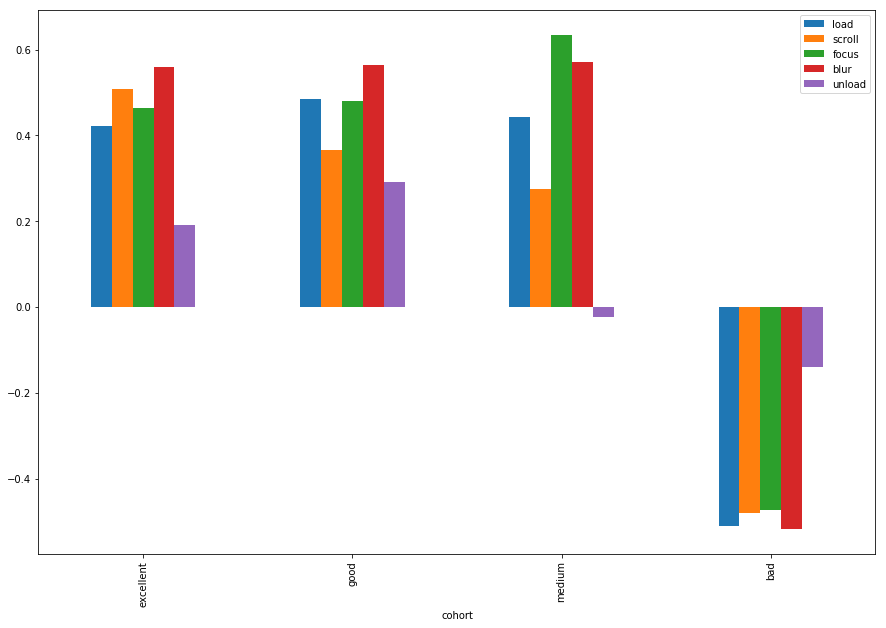

In [20]:
activityColumns = ['eigenvalues','load','scroll','focus','blur','unload']
pc1excellentCohort = loadingsArrayExcellentCohort.loc[(slice(None), slice(1)), activityColumns] #only show principle component 1
pc1BadCohort = loadingsArrayBadCohort.loc[(slice(None), slice(1)), activityColumns]
pc1MediumCohort = loadingsArrayMediumCohort.loc[(slice(None), slice(1)), activityColumns] #only show principle component 1
pc1GoodCohort = loadingsArrayGoodCohort.loc[(slice(None), slice(1)), activityColumns] #only show principle component 1

dataBar = pd.DataFrame(columns=activityColumns)
dataBar = pd.concat([pc1excellentCohort,pc1GoodCohort,pc1MediumCohort,pc1BadCohort])
dataBar['cohort'] = ['excellent','good','medium','bad'] 
dataBar = dataBar.set_index('cohort')
dataBar = dataBar.drop(['eigenvalues'],axis=1)
#import seaborn as sns
#sns.set(rc={'figure.figsize':(20, 15)})
dataBar.plot(kind='bar', figsize=(15, 10))
plt.show()

In [21]:
dataBar

,load,scroll,focus,blur,unload
cohort,,,,,
excellent,0.421529,0.507479,0.463449,0.559659,0.191770
good,0.483730,0.365132,0.480526,0.563253,0.290732
medium,0.443467,0.276155,0.633547,0.570269,-0.022066
bad,-0.509157,-0.479521,-0.473011,-0.517199,-0.139947


In [31]:
dropColumn1 = ['correct','failed','passed','version','timeout',
                                'mark','mark_overall']
temp = mediumCohort.drop(dropColumn1, axis=1)   

corr = temp.corr()

In [32]:
corr

,load,scroll,focus,blur,unload
load,1.000000,-0.247341,0.569987,0.364315,-0.103649
scroll,-0.247341,1.000000,0.354497,0.346753,-0.022227
focus,0.569987,0.354497,1.000000,0.630491,-0.370406
blur,0.364315,0.346753,0.630491,1.000000,0.458997
unload,-0.103649,-0.022227,-0.370406,0.458997,1.000000


# Try Factor Analysis

In [52]:
testDataExcellent = excellentCohort.drop(dropColumn1, axis=1)
testDataBad = badCohort.drop(dropColumn1, axis=1)

In [55]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(testDataExcellent)
chi_square_value, p_value

(102.92102114446321, 6.5409276956113905e-18)

In [56]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(testDataExcellent)
kmo_model

0.36660368597811877

In [73]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

fa = FactorAnalyzer(rotation=None)
fa.fit(testDataExcellent)
FactorAnalyzer(bounds=(0.005, 1), is_corr_matrix=False,
        method='minres', n_factors=2, rotation=None, rotation_kwargs={},
        use_smc=True)
fa.loadings_



array([[ 0.64101957,  0.36796286,  0.52894075],
       [ 0.65264943, -0.1546935 ,  0.14341833],
       [ 0.72769672, -0.62692713, -0.03406036],
       [ 0.92887691,  0.01164037, -0.36338757],
       [ 0.33941239,  0.91478561, -0.20722677]])

In [70]:
fa.get_eigenvalues()

(array([2.50917151, 1.44482824, 0.60872097, 0.40154452, 0.03573476]),
 array([ 2.34441117e+00,  1.38933065e+00,  4.76499986e-01,  4.98328337e-06,
        -5.34164075e-07]))

In [65]:
loadingsArrayExcellentCohort

explained_var_ratio  eigenvalues      load    scroll     focus  \
date       pc                                                                   
2018-09-30 1              0.501834     2.590113  0.421529  0.507479  0.463449   
           2              0.288966     1.491436  0.373189 -0.162070 -0.514368   
           3              0.121744     0.628357  0.638430  0.369808 -0.164359   

                   blur    unload  
date       pc                      
2018-09-30 1   0.559659  0.191770  
           2   0.033402  0.754170  
           3  -0.569292 -0.323331

In [67]:
fa.

array([0.82608108, 0.47045017, 0.92374025, 0.99499834, 0.99497642])